#Make necessary imports and intallations

In [1]:
!pip install timm==0.6.13

In [1]:
!git clone https://github.com/dataflowr/Project-vit-explain.git

Cloning into 'Project-vit-explain'...


In [3]:
%cd Project-vit-explain

d:\Desktop\3A\P2\EA\Project\Final\Project-vit-explain


c:\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
!dir

 Volume in drive D has no label.
 Volume Serial Number is 82C8-C352

 Directory of d:\Desktop\3A\P2\EA\Project\Final\Project-vit-explain

11-Mar-25  02:53 AM    <DIR>          .
11-Mar-25  02:53 AM    <DIR>          ..
11-Mar-25  02:53 AM    <DIR>          examples
11-Mar-25  02:53 AM             1,094 LICENSE
11-Mar-25  02:53 AM             4,817 Readme.md
11-Mar-25  02:53 AM             3,185 vit_explain.py
11-Mar-25  02:53 AM             2,516 vit_grad_rollout.py
11-Mar-25  02:53 AM             2,340 vit_rollout.py
               5 File(s)         13,952 bytes
               3 Dir(s)  143,657,070,592 bytes free


In [8]:
import os
import urllib.request
import tarfile
import shutil
import numpy as np
from torchvision import datasets
from PIL import Image
import torch
from torchvision import transforms
import cv2

from vit_grad_rollout import VITAttentionGradRollout
from vit_rollout import VITAttentionRollout

import pandas as pd
import matplotlib.pyplot as plt

def show_image(image):
    """display an image using OpenCV and Matplotlib."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib uses RGB)
    plt.imshow(image)
    plt.axis('off') 
    plt.show()


# Define the transformation for the attack

In [6]:

def transform_im(np_img, mask , beta, p0):
  '''mask with values between 0 and 1, beta tells how much we want to saturate, p0 is the basleline transform proba'''
  print()
  n, m,_= np_img.shape
  random=np.random.uniform(0, 1, (n,m))
  #baseline : uniform proba of perturabation

  baseline_thresholds=p0*np.ones((n,m))
  sum_mask=np.sum(mask**(beta))
  norm_coeft=p0*n*m/sum_mask
  new_threshold=norm_coeft*mask**(beta)

  random_values=255*np.random.uniform(0, 1, np_img.shape)

  indices_baseline= np.where(random < baseline_thresholds)
  baseline_transformed = np_img.copy()
  baseline_transformed[indices_baseline[0],indices_baseline[1],:]=random_values[indices_baseline[0],indices_baseline[1],:]


  #new : formula given in the slides
  indices_new=np.where(random < new_threshold)
  new_transformed=np_img.copy()
  new_transformed[indices_new[0],indices_new[1],:]=random_values[indices_new[0],indices_new[1],:]

  return baseline_transformed, new_transformed


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])






## Visualize the attack

Using cache found in C:\Users\aliel/.cache\torch\hub\facebookresearch_deit_main


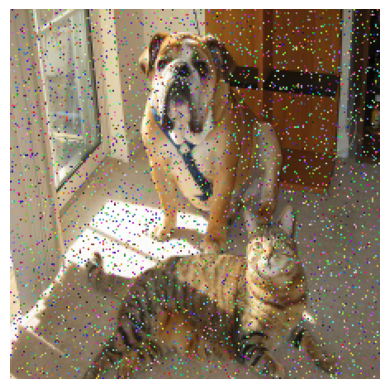

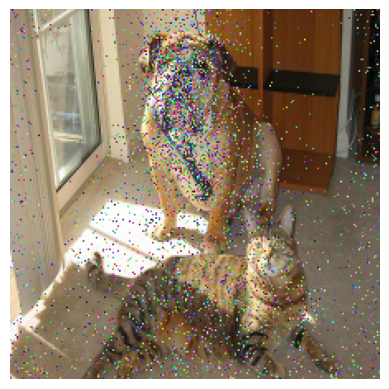

In [9]:

image_path = "examples/both.png"
img = Image.open(image_path)
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0)

model = torch.hub.load('facebookresearch/deit:main',
'deit_tiny_patch16_224', pretrained=True)

attention_rollout = VITAttentionRollout(model, head_fusion="mean",
        discard_ratio=0.8)
mask = attention_rollout(input_tensor)


np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))

beta=2
p0=0.1
base_tf, new_tf=transform_im(np_img, mask, beta, p0)

show_image(base_tf)
show_image(new_tf)

# Load a dataset to evaluate how much the attack affects results

In [10]:
DATASET_DIR = "./imagenette320"
IMAGENETTE_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz"
IMAGENETTE_TAR = os.path.join(DATASET_DIR, "imagenette-320.tgz")
EXTRACTED_DIR = os.path.join(DATASET_DIR, "imagenette-320")
OUTPUT_DIR = "./imagenette_numpy"

if not os.path.exists(EXTRACTED_DIR):
    os.makedirs(DATASET_DIR, exist_ok=True)
    if not os.path.exists(IMAGENETTE_TAR):
        print("Downloading Imagenette...")
        urllib.request.urlretrieve(IMAGENETTE_URL, IMAGENETTE_TAR)
    with tarfile.open(IMAGENETTE_TAR, "r:gz") as tar_ref:
        tar_ref.extractall(DATASET_DIR)

dataset = datasets.ImageFolder(root=EXTRACTED_DIR)

os.makedirs(OUTPUT_DIR, exist_ok=True)
for i, (img_path, _) in enumerate(dataset.imgs[:100]):
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    np.save(os.path.join(OUTPUT_DIR, f"image_{i:03d}.npy"), img_array)



# Define the evaluation protocol

In [11]:
def compute_scores(image_list, mask_list, beta_list, p0_list, model, csv_file):
    """
    We chose to store the scores in csv files to avoid starting again long comutatons"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # preds without alteration
    default_classes = []

    to_tensor_normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    with torch.no_grad():
        for image in image_list:
            image_resized = cv2.resize(image, (224, 224))
            image_tensor = to_tensor_normalize(Image.fromarray(image_resized)).unsqueeze(0).to(device)
            output = model(image_tensor)
            predicted = torch.argmax(output, dim=1)
            default_classes.append(predicted)

    with torch.no_grad():
        for p0 in p0_list:
            partial_rows = []
            for beta in beta_list:
                correct_baseline, correct_new, total = 0, 0, 0

                for i, image in enumerate(image_list):
                    mask = mask_list[i]
                    baseline_tf, new_tf = transform_im(image, mask, beta, p0)

                    baseline_tensor = to_tensor_normalize(Image.fromarray(baseline_tf)).unsqueeze(0).to(device)
                    new_tensor = to_tensor_normalize(Image.fromarray(new_tf)).unsqueeze(0).to(device)

                    base_output = model(baseline_tensor)
                    new_output = model(new_tensor)

                    base_predicted = torch.argmax(base_output, dim=1)
                    new_predicted  = torch.argmax(new_output, dim=1)


                    # compare with initial prediction
                    if base_predicted.item() == default_classes[i].item():
                        correct_baseline += 1
                    if new_predicted.item() == default_classes[i].item():
                        correct_new += 1

                    total += 1

                baseline_accuracy = 100.0 * correct_baseline / total
                new_accuracy      = 100.0 * correct_new      / total

                print(f"beta={beta}, p0={p0}: Baseline Accuracy: {baseline_accuracy:.2f}%")
                print(f"             New Transform Accuracy: {new_accuracy:.2f}%")

                # Store results
                row = {
                    "beta": beta,
                    "p0": p0,
                    "baseline_accuracy": baseline_accuracy,
                    "new_accuracy": new_accuracy
                }
                partial_rows.append(row)

            partial_df = pd.DataFrame(partial_rows)

            if os.path.exists(csv_file):
                existing = pd.read_csv(csv_file)
                final_df = pd.concat([existing, partial_df], ignore_index=True)
            else:
                final_df = partial_df

            final_df.to_csv(csv_file, index=False)
            print(f"\nResults for p0={p0} appended to {csv_file}\n")

    print("results saved to:", csv_file)

def masks_rollout(image_list, model):
    mask_list = []
    attention_rollout = VITAttentionRollout(model)
    for image in image_list:
        image_tensor = transform(Image.fromarray(image)).unsqueeze(0)
        mask = attention_rollout(image_tensor)
        mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))

        mask_list.append(mask)
    return mask_list




In [12]:
def plot_csv(csv_file, betas=None, p0s=None):
  """betas and p0s are lists of values choose which data to plot"""

  df = pd.read_csv(csv_file)
  df["beta"] = df["beta"].astype(float)
  df["p0"] = df["p0"].astype(float)
  if betas is not None:
      df = df[df["beta"].isin(betas)]
  if p0s is not None:
      df = df[df["p0"].isin(p0s)]
  if df.empty:
      print("No data remains after filtering. Check your beta/p0 filters.")
      return
  if "new_accuracy" not in df.columns:
      print("Column 'new_accuracy' not found in the CSV.")
      return
  plt.figure(figsize=(8, 6))
  for unique_beta in sorted(df["beta"].unique()):
      subset = df[df["beta"] == unique_beta].sort_values("p0")
      plt.plot(
          subset["p0"],
          subset["new_accuracy"],
          marker='o',
          label=f"beta={unique_beta}"
      )

  plt.xlabel("p0 values")
  plt.ylabel("New Accuracy (%)")
  plt.title("Filtered Evolution of New Accuracy vs. p0")
  plt.xscale("log")
  plt.legend()
  plt.grid(True)
  plt.show()


# Test on a small handmade dataset

In [14]:

dossier_images = "test_images"


image_names = [f for f in os.listdir(dossier_images)]
image_list = [
    cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(dossier_images, f)), cv2.COLOR_BGR2RGB), (224, 224))
    for f in image_names
]

mask_list=masks_rollout(image_list,model)


In [15]:
beta_list=[0,0.2, 0.5, 0.8, 1.2, 2]
p0_list=[0.01, 0.1, 0.2, 0.3]
csv_file = "acc_rollout.csv"
compute_scores(image_list, mask_list, beta_list, p0_list, model, csv_file)










beta=0, p0=0.01: Baseline Accuracy: 55.56%
             New Transform Accuracy: 55.56%









beta=0.2, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 55.56%









beta=0.5, p0=0.01: Baseline Accuracy: 77.78%
             New Transform Accuracy: 66.67%









beta=0.8, p0=0.01: Baseline Accuracy: 77.78%
             New Transform Accuracy: 66.67%









beta=1.2, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 44.44%









beta=2, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 55.56%

Results for p0=0.01 appended to acc_rollout.csv










beta=0, p0=0.1: Baseline Accuracy: 33.33%
             New Transform Accuracy: 33.33%









beta=0.2, p0=0.1: Baseline Accuracy: 33.33%
             New Transform Accuracy: 44.44%









beta=0.5, p0=0.1: Baseline Accuracy: 55.56%
             New Transform Accuracy: 33.33%









beta=0.8, p0=0.1: Baseline Accuracy: 33.33%
             New Transfo

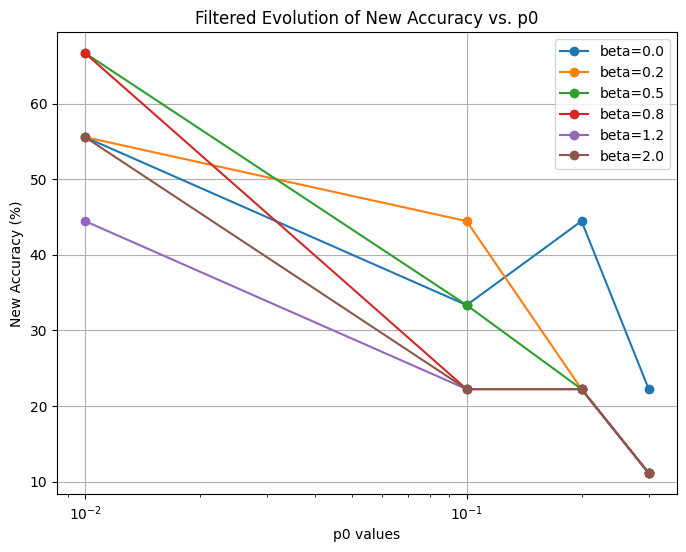

In [16]:
plot_csv(csv_file, betas=[0,1,0.2, 0.5, 0.8, 1.2, 2])

# Test on part of the loaded dataset

In [18]:

dossier_images2 = "imagenette320/imagenette-320/val/n02102040"

image_names2 = [f for f in os.listdir(dossier_images2)]
image_list2 = [
    cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(dossier_images2, f)), cv2.COLOR_BGR2RGB), (224, 224))
    for f in image_names2
]
mask_list2=masks_rollout(image_list2,model)



In [19]:
beta_list=[0,0.2, 0.5, 0.8, 1.2, 2]
p0_list=[0.01, 0.1, 0.2, 0.3]
csv_file = "att_rollout2.csv"
compute_scores(image_list2, mask_list2, beta_list, p0_list, model, csv_file)




















































beta=0, p0=0.01: Baseline Accuracy: 92.00%
             New Transform Accuracy: 92.00%


















































beta=0.2, p0=0.01: Baseline Accuracy: 90.00%
             New Transform Accuracy: 90.00%


















































beta=0.5, p0=0.01: Baseline Accuracy: 86.00%
             New Transform Accuracy: 86.00%


















































beta=0.8, p0=0.01: Baseline Accuracy: 80.00%
             New Transform Accuracy: 84.00%


















































beta=1.2, p0=0.01: Baseline Accuracy: 88.00%
             New Transform Accuracy: 88.00%


















































beta=2, p0=0.01: Baseline Accuracy: 90.00%
             New Transform Accuracy: 84.00%

Results for p0=0.01 appended to att_rollout2.csv



















































beta=0, p0=0.1: Baseline Accuracy: 70.00%
             New Transform 

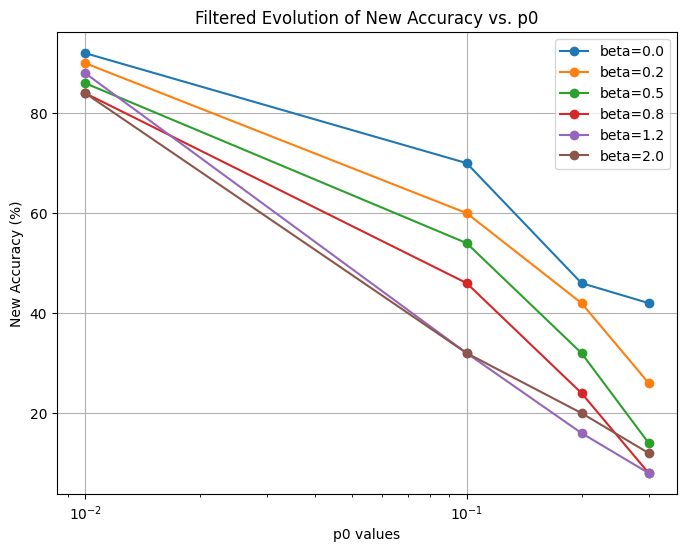

In [20]:
plot_csv(csv_file, betas=[0,1,0.2, 0.5, 0.8, 1.2, 2])

# Attention Flow

The masks have been computed separately and stored because of long computation timee

In [23]:
import csv
def extract_heatmaps_from_csv(csv_filename):
    heatmaps = {}
    with open(csv_filename, mode='r') as csv_file:
        reader = csv.reader(csv_file)
        # Skip header
        header = next(reader)
        for row in reader:
            filename = row[0]
            values = np.array([float(x) for x in row[1:]])
            heatmap_matrix = values.reshape(14, 14)
            heatmaps[filename] = heatmap_matrix
    return heatmaps


dico_heatmaps=extract_heatmaps_from_csv("heatmaps.csv")
mask_list_flow=[dico_heatmaps[key] for key in dico_heatmaps ]
mask_list_flow = [cv2.resize(mask_list_flow[i], (image_list[i].shape[1], image_list[i].shape[0])) for i in range(len(image_list))]





In [28]:
beta_list=[0,1,0.2, 0.5, 0.8, 1.2, 2]
p0_list=[0.01, 0.1, 0.2, 0.3]
csv_file = "att_flow.csv"
compute_scores(image_list, mask_list_flow, beta_list, p0_list, model, csv_file)










beta=0, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 66.67%









beta=1, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 55.56%









beta=0.2, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 77.78%









beta=0.5, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 77.78%









beta=0.8, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 66.67%









beta=1.2, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 77.78%









beta=2, p0=0.01: Baseline Accuracy: 66.67%
             New Transform Accuracy: 66.67%

Results for p0=0.01 appended to att_flow.csv










beta=0, p0=0.1: Baseline Accuracy: 33.33%
             New Transform Accuracy: 33.33%









beta=1, p0=0.1: Baseline Accuracy: 55.56%
             New Transform Accuracy: 33.33%









beta=0.2, p0=0.1: Baseline Accuracy: 44.44%
             New Transform Acc

MemoryError: Unable to allocate 1.15 MiB for an array with shape (224, 224, 3) and data type float64

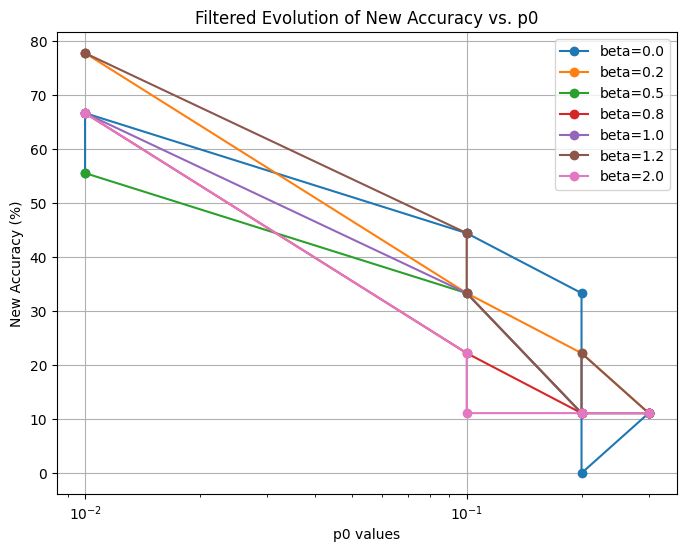

In [ ]:
plot_csv(csv_file, betas=[0,1,0.2, 0.5, 0.8, 1.2, 2])